In [ ]:
%pip install imblearn

In [2]:
import yaml
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

**1. TO DO LIST**
1. Missing value handling
    1.1. pm10 : mean kelas<br>
    1.2. pm25 : mean kelas<br>
    1.3. so2 : mean<br>
    1.4. co : median<br>
    1.5. o3 : median<br>
    1.6. no2 : median<br>
2. Join kategori sedang dan tidak sehat menjadi tidak baik<br>
3. Balancing label baik dan tidak baik<br>
4. Outlier removal

In [7]:
params_dir = "../config/config.yaml"

In [4]:
def load_params(param_dir):
    with open(param_dir, "r") as file:
        params = yaml.safe_load(file)
        
    return params

In [5]:
def params_updater(key, value, params, params_dir):
    params = params.copy()
    params[key] = value

    with open(params_dir, "w") as file:
        yaml.dump(params, file)
    
    params = load_params(params_dir)

    return params

In [8]:
params = load_params(params_dir)

In [9]:
params

{'dataset_dir': 'data/raw/',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'missing_value_co': 11,
 'missing_value_no2': 18,
 'missing_value_o3': 29,
 'missing_value_pm10': {'BAIK': 28, 'TIDAK BAIK': 55},
 'missing_value_pm25': {'BAIK': 38, 'TIDAK BAIK': 82},
 'missing_value_so2': 35,
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

**3. LOAD DATASET**

In [11]:
x_train = joblib.load("../data/processed/x_train.pkl")
y_train = joblib.load("../data/processed/y_train.pkl")

x_valid = joblib.load("../data/processed/x_valid.pkl")
y_valid = joblib.load("../data/processed/y_valid.pkl")

x_test = joblib.load("../data/processed/x_test.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

In [12]:
dataset = pd.concat([x_train, y_train], axis = 1)

valid_set = pd.concat([x_valid, y_valid], axis = 1)

test_set = pd.concat([x_test, y_test], axis = 1)

**4. JOIN CATEGORIES**

In [13]:
def join_cat(set_data, params):
    if params["label"] in set_data.columns.to_list():
        set_data = set_data.copy()
        set_data.categori.replace(params["label_categories"][1], params["label_categories"][2], inplace = True)
        set_data.categori.replace(params["label_categories"][2], params["label_categories_new"][1], inplace = True)
        return set_data
    else:
        raise RuntimeError("Kolom label tidak terdeteksi pada set data yang diberikan!")

In [14]:
params = params_updater("label", "categori", params, params_dir)
params = params_updater("label_categories", ["BAIK", "SEDANG", "TIDAK SEHAT"], params, params_dir)
params = params_updater("label_categories_new", ["BAIK", "TIDAK BAIK"], params, params_dir)

In [15]:
params

{'dataset_dir': 'data/raw/',
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'missing_value_co': 11,
 'missing_value_no2': 18,
 'missing_value_o3': 29,
 'missing_value_pm10': {'BAIK': 28, 'TIDAK BAIK': 55},
 'missing_value_pm25': {'BAIK': 38, 'TIDAK BAIK': 82},
 'missing_value_so2': 35,
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co': [-1, 100],
 'range_no2': [-1, 100],
 'range_o3': [-1, 160],
 'range_pm10': [-1, 800],
 'range_pm25': [-1, 400],
 'range_so2': [-1, 500],
 'range_stasiun': ['DKI1 (Bunderan HI)',
  'DKI2 (Kelapa Gading)',
  'DKI3 (Jagakarsa)',
  'DKI4 (Lubang Buaya)',
  'DKI5 (Kebon Jeruk) Jakarta Barat']}

**4.1 Train Set**

In [16]:
dataset.categori.value_counts()

categori
SEDANG         914
TIDAK SEHAT    223
BAIK           132
Name: count, dtype: int64

In [ ]:
dataset = join_cat(dataset, params)

In [18]:
dataset.categori.value_counts()

categori
TIDAK BAIK    1137
BAIK           132
Name: count, dtype: int64

**4.2 Validation Set**

In [19]:
valid_set.categori.value_counts()

categori
SEDANG         196
TIDAK SEHAT     48
BAIK            28
Name: count, dtype: int64

In [ ]:
valid_set = join_cat(valid_set, params)

In [21]:
valid_set.categori.value_counts()

categori
TIDAK BAIK    244
BAIK           28
Name: count, dtype: int64

**4.3 Train Set**

In [22]:
test_set.categori.value_counts()

categori
SEDANG         195
TIDAK SEHAT     48
BAIK            29
Name: count, dtype: int64

In [ ]:
test_set = join_cat(test_set, params)

In [24]:
test_set.categori.value_counts()

categori
TIDAK BAIK    243
BAIK           29
Name: count, dtype: int64

# 5. Handling Missing Value

In [25]:
def nan_detector(set_data):
    set_data = set_data.copy()
    set_data.replace(-1, np.nan, inplace = True)
    return set_data

## 5.1 Convert -1 to NaN

### 5.1.1. Train Set

In [26]:
# TRAIN SET
dataset.describe()

,pm10,pm25,so2,co,o3,no2
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000
mean,51.152088,75.731284,33.360126,11.536643,30.835303,19.267928
std,17.246488,29.306460,14.710573,5.045186,15.319329,9.231295
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,42.000000,60.000000,25.000000,8.000000,21.000000,13.000000
50%,54.000000,77.000000,34.000000,11.000000,28.000000,18.000000
75%,62.000000,93.000000,43.000000,14.000000,37.000000,25.000000
max,100.000000,174.000000,82.000000,44.000000,151.000000,65.000000


In [27]:
dataset.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [28]:
dataset = nan_detector(dataset)

In [29]:
dataset.isnull().sum()

stasiun      0
pm10        35
pm25        55
so2         68
co          10
o3          35
no2          9
categori     0
dtype: int64

### 5.1.2. Validation Set

In [30]:
valid_set.describe()

,pm10,pm25,so2,co,o3,no2
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,51.496324,75.459559,34.341912,11.290441,32.533088,18.786765
std,17.315394,28.640510,15.026324,5.297794,14.238053,9.295802
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,43.000000,60.000000,26.000000,8.000000,23.000000,12.000000
50%,54.000000,77.000000,34.000000,10.500000,30.000000,17.000000
75%,62.000000,95.000000,45.000000,13.000000,41.000000,24.250000
max,94.000000,150.000000,80.000000,47.000000,85.000000,62.000000


In [31]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [32]:
valid_set = nan_detector(valid_set)

In [33]:
valid_set.isnull().sum()

stasiun      0
pm10         9
pm25        13
so2         15
co           3
o3           3
no2          4
categori     0
dtype: int64

### 5.1.3. Test Set

In [34]:
test_set.describe()

,pm10,pm25,so2,co,o3,no2
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,51.121324,73.444853,32.360294,11.816176,31.194853,18.669118
std,18.589466,29.945903,14.567148,5.170456,16.550122,8.879725
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,40.000000,59.000000,23.000000,9.000000,21.000000,13.000000
50%,54.000000,76.000000,32.000000,11.000000,28.000000,18.000000
75%,61.000000,91.000000,43.000000,14.000000,38.250000,24.000000
max,179.000000,150.000000,64.000000,44.000000,93.000000,49.000000


In [35]:
test_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [36]:
test_set = nan_detector(test_set)

In [37]:
test_set.isnull().sum()

stasiun      0
pm10         9
pm25        18
so2         14
co           3
o3          10
no2          6
categori     0
dtype: int64

## 5.2 Handling in PM10

### 5.2.1. Trainset

In [38]:
impute_1 = int(dataset[dataset.categori == "BAIK"].pm10.mean())
impute_0 = int(dataset[dataset.categori == "TIDAK BAIK"].pm10.mean())

In [39]:
impute_1, impute_0

(28, 55)

In [40]:
params = params_updater("missing_value_pm10", {"BAIK": 28, "TIDAK BAIK": 55}, params, params_dir)

In [41]:
dataset[dataset.categori == "BAIK"].pm10.isnull().sum(), dataset[dataset.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(5), np.int64(30))

In [42]:
dataset.loc[dataset[(dataset.categori == "BAIK") & (dataset.pm10.isnull() == True)].index, "pm10"] = impute_1
dataset.loc[dataset[(dataset.categori == "TIDAK BAIK") & (dataset.pm10.isnull() == True)].index, "pm10"] = impute_0

In [43]:
dataset[dataset.categori == "BAIK"].pm10.isnull().sum(), dataset[dataset.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(0), np.int64(0))

### 5.2.2. Validation Set

In [44]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(2), np.int64(7))

In [45]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK BAIK") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [46]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(0), np.int64(0))

### 5.2.3. Test Set

In [47]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(3), np.int64(6))

In [48]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK BAIK") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [49]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(0), np.int64(0))

## 5.3 Handling in PM25

### 5.3.1. Train Set

In [ ]:
impute_1 = int(dataset[dataset.categori == "BAIK"].pm25.mean())
impute_0 = int(dataset[dataset.categori == "TIDAK BAIK"].pm25.mean())

In [50]:
impute_0, impute_1

(55, 28)

In [52]:
params = params_updater("missing_value_pm25", {"BAIK": 55, "TIDAK BAIK": 28}, params, params_dir)

In [51]:
dataset[dataset.categori == "BAIK"].pm25.isnull().sum(), dataset[dataset.categori == "TIDAK BAIK"].pm25.isnull().sum()

(np.int64(35), np.int64(20))

In [55]:
dataset.loc[dataset[(dataset.categori == "BAIK") & (dataset.pm25.isnull() == True)].index, "pm25"] = impute_1
dataset.loc[dataset[(dataset.categori == "TIDAK BAIK") & (dataset.pm25.isnull() == True)].index, "pm25"] = impute_0

In [56]:
dataset[dataset.categori == "BAIK"].pm25.isnull().sum(), dataset[dataset.categori == "TIDAK BAIK"].pm25.isnull().sum()

(np.int64(0), np.int64(0))

### 5.3.2. Validation Set

In [57]:
valid_set[valid_set.categori == "BAIK"].pm25.isnull().sum(), valid_set[valid_set.categori == "TIDAK BAIK"].pm25.isnull().sum()

(np.int64(5), np.int64(8))

In [58]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK BAIK") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [61]:
valid_set[valid_set.categori == "BAIK"].pm25.isnull().sum(), valid_set[valid_set.categori == "TIDAK BAIK"].pm25.isnull().sum()

(np.int64(0), np.int64(0))

### 5.3.3. Test Set

In [62]:
test_set[test_set.categori == "BAIK"].pm25.isnull().sum(), test_set[test_set.categori == "TIDAK BAIK"].pm25.isnull().sum()

(np.int64(10), np.int64(8))

In [63]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK BAIK") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [64]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK BAIK"].pm10.isnull().sum()

(np.int64(0), np.int64(0))

## 5.4 Handling in SO2, CO, O3, dan NO2

### 5.4.1. Train Set

In [65]:
impute_so2 = int(dataset.so2.mean())
impute_co = int(dataset.co.median())
impute_o3 = int(dataset.o3.median())
impute_no2 = int(dataset.no2.median())

In [66]:
impute_values = {"so2" : impute_so2, "co" : impute_co, "o3" : impute_o3, "no2" : impute_no2}

In [67]:
impute_values

{'so2': 35, 'co': 11, 'o3': 29, 'no2': 18}

In [68]:
params = params_updater("missing_value_so2", 35, params, params_dir)
params = params_updater("missing_value_co", 11, params, params_dir)
params = params_updater("missing_value_o3", 29, params, params_dir)
params = params_updater("missing_value_no2", 18, params, params_dir)

In [69]:
dataset.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         68
co          10
o3          35
no2          9
categori     0
dtype: int64

In [70]:
dataset.fillna(value = impute_values, inplace = True)

In [71]:
dataset.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

### 5.4.2. Validation Set

In [72]:
valid_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         15
co           3
o3           3
no2          4
categori     0
dtype: int64

In [73]:
valid_set.fillna(value = impute_values, inplace = True)

In [74]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

### 5.4.3. Test Set

In [75]:
test_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         14
co           3
o3          10
no2          6
categori     0
dtype: int64

In [76]:
test_set.fillna(value = impute_values, inplace = True)

In [77]:
test_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

# 6. Encoding Stasiun

In [78]:
ohe_statiun = OneHotEncoder(sparse_output = False)

In [79]:
ohe_statiun.fit(np.array(params["range_stasiun"]).reshape(-1, 1))

OneHotEncoder(sparse_output=False)

In [80]:
ohe_statiun.categories_

[array(['DKI1 (Bunderan HI)', 'DKI2 (Kelapa Gading)', 'DKI3 (Jagakarsa)',
        'DKI4 (Lubang Buaya)', 'DKI5 (Kebon Jeruk) Jakarta Barat'],
       dtype='<U32')]

In [83]:
joblib.dump(ohe_statiun, "../models/ohe_stasiun.pkl")

['../models/ohe_stasiun.pkl']

## 6.1. Train Set

In [84]:
stasiun_features = ohe_statiun.transform(np.array(dataset.stasiun.to_list()).reshape(-1, 1))

In [85]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [86]:
stasiun_features.set_index(dataset.index, inplace = True)

In [87]:
dataset = pd.concat([stasiun_features, dataset], axis = 1)

In [88]:
dataset.drop(columns = "stasiun", inplace = True)

## 6.2. Validation Test

In [90]:
stasiun_features = ohe_statiun.transform(np.array(valid_set.stasiun.to_list()).reshape(-1, 1))

In [91]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [92]:
stasiun_features.set_index(valid_set.index, inplace = True)

In [93]:
valid_set = pd.concat([stasiun_features, valid_set], axis = 1)

In [94]:
valid_set.drop(columns = "stasiun", inplace = True)

## 6.3. Test Set

In [95]:
stasiun_features = ohe_statiun.transform(np.array(test_set.stasiun.to_list()).reshape(-1, 1))

In [96]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [97]:
stasiun_features.set_index(test_set.index, inplace = True)

In [98]:
test_set = pd.concat([stasiun_features, test_set], axis = 1)

In [103]:
test_set.drop(columns = "stasiun", inplace = True)

# 7. Balancing Label

<Axes: xlabel='categori', ylabel='Count'>

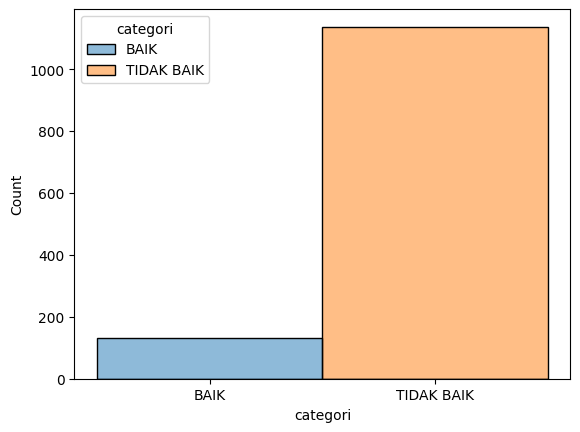

In [108]:
sns.histplot(data = dataset, x = "categori", hue = "categori")

## 7.1. Undersampling

In [109]:
rus = RandomUnderSampler(random_state = 26)

In [110]:
x_rus, y_rus = rus.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [111]:
dataset_rus = pd.concat([x_rus, y_rus], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

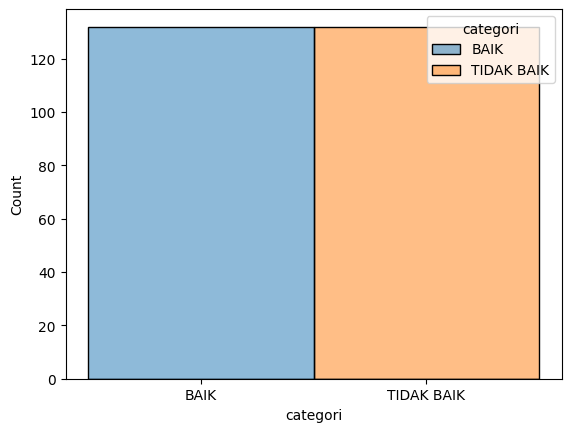

In [112]:
sns.histplot(dataset_rus, x = "categori", hue = "categori")

## 7.2. Oversampling

In [104]:
ros = RandomOverSampler(random_state = 11)

In [105]:
x_ros, y_ros = ros.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [106]:
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

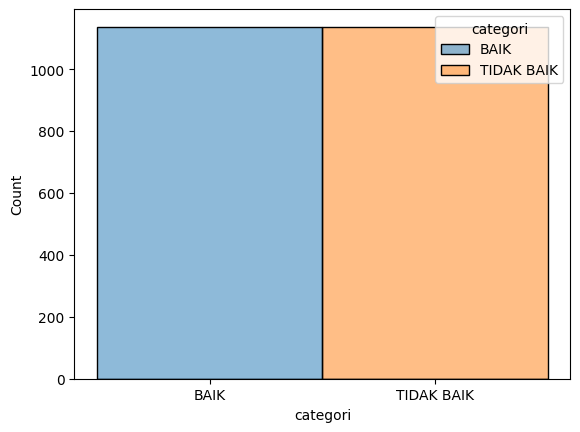

In [107]:
sns.histplot(dataset_ros, x = "categori", hue = "categori")

## 7.3. SMOTE

In [113]:
sm = SMOTE(random_state = 112)

In [117]:
x_sm, y_sm = sm.fit_resample(dataset.drop("categori", axis = 1), dataset.categori)

In [118]:
dataset_sm = pd.concat([x_sm, y_sm], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

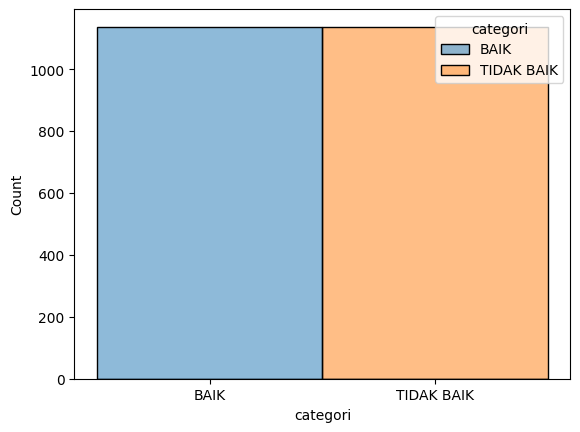

In [119]:
sns.histplot(dataset_sm, x = "categori", hue = "categori")

# 8. Label Encoding

In [120]:
le_categori = LabelEncoder()

In [121]:
le_categori.fit(params["label_categories_new"])

LabelEncoder()

In [123]:
joblib.dump(le_categori, "../models/le_categori.pkl")

['../models/le_categori.pkl']

In [124]:
params["label_categories_new"]

['BAIK', 'TIDAK BAIK']

## 8.1. Undersampling Set

In [125]:
list(y_rus.unique()) == params["label_categories_new"]

True

In [126]:
y_rus = le_categori.transform(y_rus)

In [127]:
y_rus

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 8.2. Oversampling Set

In [128]:
list(y_ros.unique()) == params["label_categories_new"]

True

In [129]:
y_ros = le_categori.transform(y_ros)

In [130]:
y_ros

array([0, 1, 0, ..., 0, 0, 0], shape=(2274,))

## 8.3. SMOTE Set

In [131]:
list(y_sm.unique()) == params["label_categories_new"]

True

In [132]:
y_sm = le_categori.transform(y_sm)

In [133]:
y_sm

array([0, 1, 0, ..., 0, 0, 0], shape=(2274,))

## 8.4. Validation Set

In [134]:
len(set(valid_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [135]:
valid_set.categori = le_categori.transform(valid_set.categori)

## 8.5. Test Set

In [136]:
len(set(test_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [137]:
test_set.categori = le_categori.transform(test_set.categori)

# 9. Dump Data Train

In [139]:
joblib.dump(x_rus, "../data/processed/x_rus.pkl")
joblib.dump(y_rus, "../data/processed/y_rus.pkl")

joblib.dump(x_ros, "../data/processed/x_ros.pkl")
joblib.dump(y_ros, "../data/processed/y_ros.pkl")

joblib.dump(x_sm, "../data/processed/x_sm.pkl")
joblib.dump(y_sm, "../data/processed/y_sm.pkl")

joblib.dump(valid_set.drop(columns = "categori"), "../data/processed/x_valid_feng.pkl")
joblib.dump(valid_set.categori, "../data/processed/y_valid_feng.pkl")

joblib.dump(test_set.drop(columns = "categori"), "../data/processed/x_test_feng.pkl")
joblib.dump(test_set.categori, "../data/processed/y_test_feng.pkl")

['../data/processed/y_test_feng.pkl']